In [1]:
import tensorflow as tf
import numpy as np

In [38]:
import os
import dataloader

In [3]:
import matplotlib.pyplot as plt
import nibabel as nib
import cv2

In [24]:
from importlib import reload

In [37]:
reload(dataloader)

<module 'dataloader' from 'c:\\Users\\Dell\\Documents\\Studia\\magisterka\\projekt\\dataloader.py'>

In [4]:
ROOT_DIR = '.'
DATA_DIR = 'BRATS_2018'
TRAIN_DIR = 'MICCAI_BraTS_2018_Data_Training'
TEST_DIR = 'MICCAI_BraTS_2018_Data_Validation'
TRAIN_PATH = os.path.join(ROOT_DIR, DATA_DIR, TRAIN_DIR)
TEST_PATH = os.path.join(ROOT_DIR, DATA_DIR, TEST_DIR)

BATCH_SIZE = 32
BRAIN_SLICES = 8
X_DTYPE = np.float32
Y_DTYPE = np.int8

In [5]:
test = nib.load('.\\BRATS_2018\\MICCAI_BraTS_2018_Data_Training\\LGG\\Brats18_TCIA12_466_1\\Brats18_TCIA12_466_1_t1.nii').get_fdata()

In [6]:
train_brains, val_brains, test_brains = dataloader.load_dataset_paths(TRAIN_PATH, TEST_PATH)

In [7]:
all_brains = train_brains + val_brains + test_brains

In [8]:
cutter = dataloader.FrameCutter()
cutter.fit(all_brains)

In [9]:
cutter.w_low_index, cutter.w_high_index, cutter.h_low_index, cutter.h_high_index

(17, 117, 23, 103)

In [17]:
cutted = cutter.transform(cv2.resize(test[:, :, 75], (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE)))

In [18]:
cutted.shape

(80, 100)

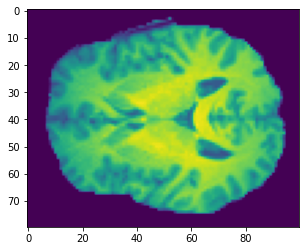

In [19]:
plt.imshow(cutted)

In [9]:
new_height = cutter.h_high_index - cutter.h_low_index
new_width = cutter.w_high_index - cutter.w_low_index

In [10]:
indexes = cutter.get_indexes()

In [39]:
dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(BATCH_SIZE, new_height, new_width, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(BATCH_SIZE, new_height, new_width), dtype=Y_DTYPE)
), args=[train_brains, indexes['h_low_index'], indexes['h_high_index'], indexes['w_low_index'], indexes['w_high_index']])

In [14]:
type(dataset)

tensorflow.python.data.ops.flat_map_op._FlatMapDataset

In [41]:
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [42]:
type(dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset